In this tutorial you will learn:
 - How the `Identifier` class is used to manage biomteric datasets
 - How to work with the `DataLoader` and `Dataset` classes 
 - How to load data from a directory of images and assign them identifiers
 - How to preprocess the data for training a DeepFinger model

## Identifier, DataLoader and Dataset

In our codebase, an `Identifier` has a `subject` (to differentiate distinct fingers) and an `impression` (to differentiate the impressions / samples taken from one finger).

Although one person can have multiple fingers, we will treat each finger as a separate subject (class) for training the DeepFinger model. This has the advantage, that the model can be trained with ten times as many classes as if we would treat each person as a class. Additionally, some datasets may not provide all ten fingers for each person.


In [1]:
from flx.data.dataset import Identifier

# Create an identifier for the first subject (first distinct finger, may belong to the same person as subject 1, 2, 3, ... 9) and second impression
# Note that we start counting from 0. This has practical reasons during training.
myid = Identifier(subject=0, impression=1)
print(myid)

assert myid == Identifier(0, 1) # With positional arguments
assert myid != Identifier(0, 3) # Equals only if both subject and impression match
assert myid != Identifier(1, 1) # Equals only if both subject and impression match

Identifier(0, 1)


To manage multiple identifiers, we use an `IdentifierSet`. This data structure has many useful functions for filtering the contained `Identifier`s and also ensures their uniqueness.

In [2]:
from flx.data.dataset import IdentifierSet

id_set = IdentifierSet(
    [
        Identifier(0, 1),
        Identifier(3, 1),
        Identifier(5, 2),
        Identifier(3, 0),
        Identifier(1, 2),
    ]
)

# Total number of identifiers
print(len(id_set))

# Count how many different subjects
print(id_set.num_subjects)

# We can access the identifiers by index. Note that they are always sorted by (subject, impression)
print(id_set[0])
print(id_set[1])
print(id_set[2])
print(id_set[3])
print(id_set[4])

# We can filter the Indentifier set according to these indices:
id_set_1to3 = id_set.filter_by_index([1, 2, 3])

# We can also check if one set is a subset of another (useful to check if some dataset is complete)
print(f"id_set is superset of id_set_1to3: {id_set >= id_set_1to3}")
print(f"id_set is subset of id_set_1to3: {id_set <= id_set_1to3}")

# identifiers can also be used as keys of a dictionary
letter_dict = {id:letter for id, letter in zip(id_set, "abcde")}

print("Letter for myid: " + letter_dict[myid])


Created IdentifierSet with 4 subjects and a total of 5 samples.
5
4
Identifier(0, 1)
Identifier(1, 2)
Identifier(3, 0)
Identifier(3, 1)
Identifier(5, 2)
Created IdentifierSet with 2 subjects and a total of 3 samples.
id_set is superset of id_set_1to3: True
id_set is subset of id_set_1to3: False
Letter for myid: a


Now that we are familiar with how `Identifiers` work, understanding `DataLoader`s and `Dataset`s is not difficult.

To implement your own `DataLoader` class you just need to derive from the abstract `DataLoader` class and then implement the `get` classmethod. This method takes a single identifier as input and returns the loaded value. There is no constraint on what can be loaded and in the `flx` codebase there are loaders for fingerprint, minutia maps, embedding vectors and other types of data.


In [3]:
import random
from flx.data.dataset import DataLoader

class StringLoader(DataLoader):
    def __init__(self, value_dict: dict[Identifier, str]):
        self.value_dict = value_dict

    def get(self, identifier: Identifier) -> str:
        return self.value_dict[identifier]

string_loader = StringLoader(letter_dict)
print(string_loader.get(myid))

class RandomNumberLoader(DataLoader):
    def get(self, identifier: Identifier) -> float:
        return random.random()

random_number_loader = RandomNumberLoader()
print(random_number_loader.get(myid))
print(random_number_loader.get(myid))

a
0.9448413036546239
0.7026130335319339


A `Dataset` is just a combination of an `IdentifierSet` and a `DataLoader`. Basically we say what is in the dataset through the `IdentifierSet` and how to access the actual values through the `DataLoader`. An advantage of this separation is, that we can easily create subsets and combine datasets, regardless of what kind of values we have in our `DataLoader`. We can even "zip" multiple datasets together!

In [4]:
from flx.data.dataset import Dataset

string_dataset = Dataset(string_loader, id_set)

# Datasets also have a get method
assert string_dataset.get(myid) == string_loader.get(myid)

# But they allow indexed access and iteration as well!
for i, s in enumerate(string_dataset):
    print(f"{i}: {s}")

# We get the IdentifierSet via the "ids" property
print(string_dataset.ids)


# Now we see how we can zip datasets
random_number_dataset = Dataset(random_number_loader, id_set)
for tpl in Dataset.zip(string_dataset, random_number_dataset):
    print(tpl)

# And how to concatenate them
some_other_ids = IdentifierSet([Identifier(i, 0) for i in range(10)])
random_number_dataset2 = Dataset(random_number_loader, some_other_ids)

# Here the subjects are shared, which means that subject 1 in dataset 1 is the same as subject 1 in dataset 2.
# The Identifiers in the new dataset will therefore have the same subject but maybe a different impression
# (as the same impression can in multiple datasets)
shared_subjects = Dataset.concatenate(random_number_dataset, random_number_dataset2, share_subjects = True)
for id in shared_subjects.ids:
    print(id)

# Here the subjects are not shared, which means that subject 1 in dataset 1 is a different subjects as subject 1 in dataset 2.
# The Identifiers in the new dataset will therefore have the same impression but maybe a different subject
# (as the same subject can appear in multiple datasets)
separate_subjects = Dataset.concatenate(random_number_dataset, random_number_dataset2, share_subjects = False)
for id in separate_subjects.ids:
    print(id)




0: a
1: b
2: c
3: d
4: e
['a', 0.5863233625310251]
['b', 0.1699814273665361]
['c', 0.8140821352622485]
['d', 0.544761654986301]
['e', 0.6511675998384293]
Created IdentifierSet with 10 subjects and a total of 10 samples.
Created IdentifierSet with 10 subjects and a total of 15 samples.
Identifier(0, 0)
Identifier(0, 1)
Identifier(1, 0)
Identifier(1, 1)
Identifier(2, 0)
Identifier(3, 0)
Identifier(3, 1)
Identifier(3, 2)
Identifier(4, 0)
Identifier(5, 0)
Identifier(5, 1)
Identifier(6, 0)
Identifier(7, 0)
Identifier(8, 0)
Identifier(9, 0)
Created IdentifierSet with 14 subjects and a total of 15 samples.
Identifier(0, 1)
Identifier(1, 2)
Identifier(2, 0)
Identifier(2, 1)
Identifier(3, 2)
Identifier(4, 0)
Identifier(5, 0)
Identifier(6, 0)
Identifier(7, 0)
Identifier(8, 0)
Identifier(9, 0)
Identifier(10, 0)
Identifier(11, 0)
Identifier(12, 0)
Identifier(13, 0)


## Loading an image dataset from disk

For loading image datasets from disk there exists the `ImageLoader` class. It does most of the work of loading and indexing the image files inside a root dir (and its subdirectories).

Take a look at the following folder structure, containing fingerprint images and fingerprint iso templates (.ist).

In [5]:
import os

def list_files(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print('{}{}/'.format(indent, os.path.basename(root)))
        subindent = ' ' * 4 * (level + 1)
        for f in files:
            print('{}{}'.format(subindent, f))

# NOTE: If this does not work, enter the absolute path to the notebooks/example-dataset directory here! 
example_dataset_path = os.path.abspath("fvc_dataset/fvc2002_DB3_B capacitive/converted")
list_files(example_dataset_path)


converted/
    108_4.png
    107_4.ist
    105_5.png
    106_4.png
    101_4.png
    104_7.ist
    106_2.png
    109_8.png
    106_3.png
    106_8.png
    101_7.png
    106_7.png
    103_6.ist
    107_6.png
    110_8.png
    106_4.ist
    102_7.png
    105_2.png
    103_8.ist
    109_7.png
    108_5.png
    103_5.png
    101_8.png
    101_6.ist
    102_7.ist
    101_4.ist
    109_7.ist
    107_2.png
    104_7.png
    101_5.ist
    108_2.png
    105_8.ist
    102_6.png
    103_1.png
    105_3.ist
    110_3.png
    108_8.png
    104_2.png
    105_3.png
    110_8.ist
    109_3.ist
    107_4.png
    110_3.ist
    108_3.ist
    102_5.png
    110_4.png
    103_5.ist
    108_4.ist
    102_4.ist
    104_6.png
    109_5.png
    110_2.png
    104_8.png
    109_4.png
    104_5.ist
    106_8.ist
    101_8.ist
    103_6.png
    108_7.png
    107_1.ist
    104_5.png
    110_7.png
    101_1.png
    110_4.ist
    109_6.png
    110_2.ist
    103_8.png
    105_8.png
    109_1.ist
    108_3.png
    102_4

As one can see, the folder structure is rather complicated, however, the subject and impression can be read from the filename directly. We can use this to index and access the whole directory with just a few lines of code!

Created IdentifierSet with 10 subjects and a total of 80 samples.
Created IdentifierSet with 10 subjects and a total of 80 samples.
torch.Size([1, 480, 300])


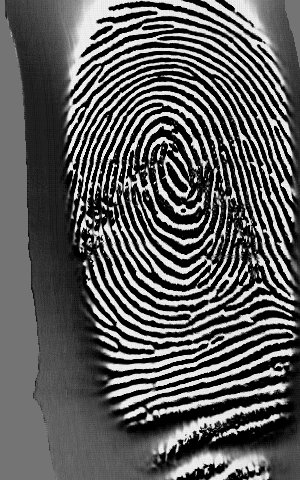

In [6]:
from flx.data.image_loader import ImageLoader

import torch
import torchvision.transforms.functional as VTF
import PIL
from IPython.display import display

# Derive from ImageLoader and implement the following three staticmethods:
class ExampleImageLoader(ImageLoader):
    # We do not need to override the __init__ method. In case you need to do it, call
    # super().__init__(<my_root_dir>)
    # with the root dir of the image dataset inside your __init__ method.
    
    @staticmethod
    def _extension() -> str:
        return ".png"

    @staticmethod
    def _file_to_id_fun(subdir: str, filename: str) -> Identifier:
        # We can ignore the subdir
        # But the filename has the pattern: <subject>_<impression>.png
        subject_id, impression_id = filename.split("_")
        return Identifier(int(subject_id), int(impression_id))
        
    @staticmethod
    def _load_image(filepath: str) -> torch.Tensor:
        img = PIL.Image.open(filepath)
        img = PIL.ImageOps.grayscale(img)
        # TODO: Resize / crop your image to the input size of DeepPrint (which is 299 x 299)#
        # Take a look at flx.data.image_loader to see how this can be done.
        
        # To be compatible with DeepPrint, we convert it to pytorch.Tensor
        # The image is now in format 1 x height x width and pixel values are scaled from [0. 255] to [0. 1]
        return VTF.to_tensor(img)
        
image_loader = ExampleImageLoader(example_dataset_path)
expected_ids = IdentifierSet([Identifier(i, j) for i in range(101,111 ) for j in range(1, 9)])
assert image_loader.ids == expected_ids # Not all DataLoaders have an identifier set, but ImageLoaders always have

image_dataset = Dataset(image_loader, expected_ids)

img = image_dataset[0]
print(img.shape)
display(VTF.to_pil_image(img))


## Preprocessing images

You can preprocess and augment your image using the `TransformedImageLoader` class. It accepts pose transformation (shift, rotation) which are applied first, followed by any number of image processing functions.

torch.Size([1, 480, 300])


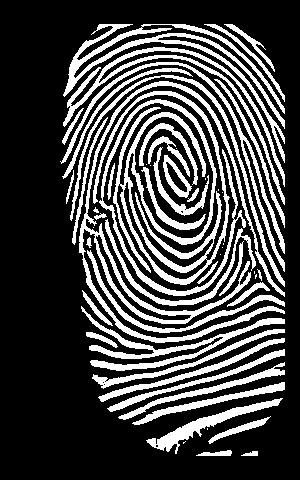

In [8]:
from flx.image_processing.augmentation import RandomPoseTransform
from flx.image_processing.binarization import LazilyAllocatedBinarizer
from flx.data.transformed_image_loader import TransformedImageLoader

transformed_images = TransformedImageLoader(
    image_loader, # Just the regular image loader
    # poses = RandomPoseTransform(), # Augment the pose; Use this during training
    transforms = [LazilyAllocatedBinarizer(ridge_width = 5.0)] # Apply Gabor Wavelets and binarize
)

image_dataset = Dataset(transformed_images, expected_ids)

img = image_dataset[0]
print(img.shape)
display(VTF.to_pil_image(img))

# Notice, that the pose transform adds padding. You may have to add a transform that crops / resizes it again to the correct size...
